In [1]:
import os
import glob
import numpy  as np
import pandas as pd
import tables as tb
import h5py

from IC.invisible_cities.reco.psf_functions    import create_psf
from IC.invisible_cities.reco.psf_functions    import hdst_psf_processing
from IC.invisible_cities.reco.psf_functions    import add_empty_sensors_and_normalize_q
from IC.invisible_cities.reco.psf_functions    import add_variable_weighted_mean

import IC.invisible_cities.core.core_functions as     coref
import IC.invisible_cities.io.dst_io         as     dstio

from IC.invisible_cities.database              import load_db
from IC.invisible_cities.io.kdst_io      import psf_writer

In [2]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]          = 10, 10
plt.rcParams["font.size"]               = 16
plt.rcParams["figure.max_open_warning"] = 100

In [3]:
db = load_db.DataSiPM('next100', -1)

In [4]:
# Input and output path
#psf_path   = '/Users/halmamol/NEXT/'
#psf_filename = 'next100.kr83m_psf200.psf.h5'
psf_path   = '/Users/halmamol/NEXT/files/NFlex/'
#psf_filename =  'FLEX.M6.06_PSF.h5'
psf_filename =  'nflex_d15_M6_H6.psf.h5'
out_psf  = psf_path + psf_filename

psf_files = glob.glob(psf_path+'psf_*.h5')

In [5]:
h5file = tb.open_file(out_psf)
h5file

File(filename=/Users/halmamol/NEXT/files/NFlex/nflex_d15_M6_H6.psf.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/PSF (Group) ''
/PSF/PSFs (Table(2440000,), shuffle, zlib(4)) 'XYZ dependent point spread functions'
  description := {
  "nevt": UInt32Col(shape=(), dflt=0, pos=0),
  "xr": Float32Col(shape=(), dflt=0.0, pos=1),
  "yr": Float32Col(shape=(), dflt=0.0, pos=2),
  "zr": Float32Col(shape=(), dflt=0.0, pos=3),
  "x": Float32Col(shape=(), dflt=0.0, pos=4),
  "y": Float32Col(shape=(), dflt=0.0, pos=5),
  "z": Float32Col(shape=(), dflt=0.0, pos=6),
  "factor": Float32Col(shape=(), dflt=0.0, pos=7)}
  byteorder := 'little'
  chunkshape := (2048,)

In [6]:
psf = pd.read_hdf(out_psf, 'PSF/PSFs')
psf.head()

,nevt,xr,yr,zr,x,y,z,factor
0,31,-99.5,-99.5,0.0,0.0,0.0,10.0,0.0
1,27,-99.5,-98.5,0.0,0.0,0.0,10.0,0.0
2,33,-99.5,-97.5,0.0,0.0,0.0,10.0,0.0
3,44,-99.5,-96.5,0.0,0.0,0.0,10.0,0.0
4,43,-99.5,-95.5,0.0,0.0,0.0,10.0,0.0


In [7]:
psf

,nevt,xr,yr,zr,x,y,z,factor
0,31,-99.5,-99.5,0.0,0.0,0.0,10.0,0.0
1,27,-99.5,-98.5,0.0,0.0,0.0,10.0,0.0
2,33,-99.5,-97.5,0.0,0.0,0.0,10.0,0.0
3,44,-99.5,-96.5,0.0,0.0,0.0,10.0,0.0
4,43,-99.5,-95.5,0.0,0.0,0.0,10.0,0.0
...,...,...,...,...,...,...,...,...
2439995,18,99.5,95.5,0.0,0.0,0.0,1210.0,0.0
2439996,18,99.5,96.5,0.0,0.0,0.0,1210.0,0.0
2439997,26,99.5,97.5,0.0,0.0,0.0,1210.0,0.0
2439998,18,99.5,98.5,0.0,0.0,0.0,1210.0,0.0


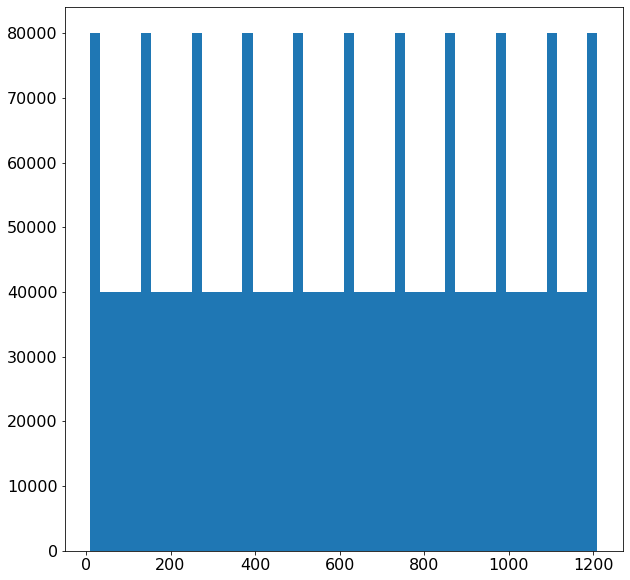

In [8]:
psf =  dstio.load_dst(out_psf, 'PSF', 'PSFs')
plt.hist(psf.z, bins=50);

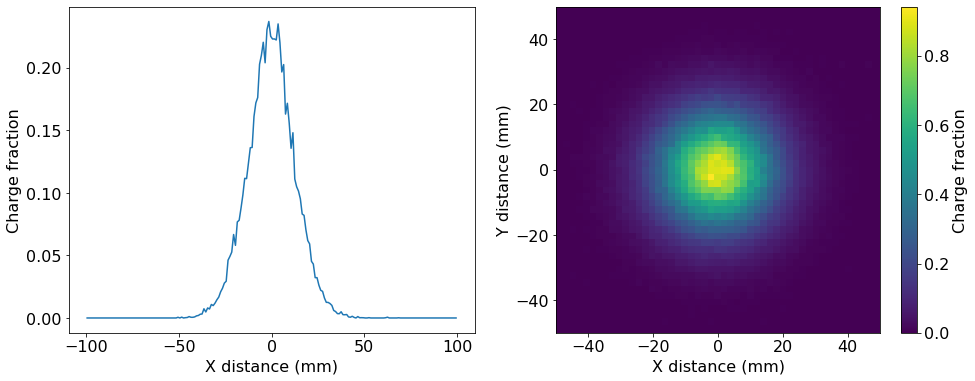

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

bin_size   = 1
Xrange     = [ -100, 100]
Yrange     = [ -100, 100]
ranges     = [Xrange, Yrange]
nbinX      = int(np.diff(Xrange)/bin_size)
nbinY      = int(np.diff(Yrange)/bin_size)

### Plot PSF at center (X dimension)
p1 = psf[(psf.z==610.) & (psf.yr==0.5)]
x, y = sorted(set(p1.xr)), p1.groupby(['xr'])['factor'].sum().values
axes[0].plot(x, y)
axes[0].set_xlabel('X distance (mm)')
axes[0].set_ylabel('Charge fraction')

### PSF (2D)
p1 = psf[(psf.z==610.)]
x, y, e = p1.xr.values, p1.yr.values, p1.factor.values
xb, yb  = np.linspace(Xrange[0], Xrange[1], Xrange[1]), np.linspace(Yrange[0], Yrange[1], Yrange[1])
img = axes[1].hist2d(x, y, bins=[xb,yb], weights=e)
axes[1].set_xlabel('X distance (mm)')
axes[1].set_ylabel('Y distance (mm)')
axes[1].set_xlim(-50, 50)
axes[1].set_ylim(-50, 50)
cb = fig.colorbar(img[3], ax=axes[1])

cb.set_label('Charge fraction')